In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re
import html

## Let's analyze Kaggle dataset first

In [ ]:
column_names = ['sentiment', 'id', 'date', 'query', 'user', 'text']

df = pd.read_parquet('../data/raw/sentiment_kaggle.parquet',
                 encoding='latin-1', names=column_names)

df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

# we will downsample the dataset to balance our youtube data

df = df.sample(100000, random_state=42)

In [51]:
df.sample(10)

,sentiment,id,date,query,user,text
1213857,1,1989391583,Mon Jun 01 01:22:05 PDT 2009,NO_QUERY,luv4tn,Good morning ... off work today (holiday in Ge...
961056,1,1826983121,Sun May 17 09:44:24 PDT 2009,NO_QUERY,ailishx14,"i just made a cake! hah, excited!"
277642,0,1991328944,Mon Jun 01 06:50:23 PDT 2009,NO_QUERY,MsWiz,Summer of checking out colleges back east for ...
108154,0,1824193404,Sun May 17 00:23:20 PDT 2009,NO_QUERY,maddiewaixel,@SteveSievers i love that song and i must be d...
1166769,1,1979988548,Sun May 31 05:17:05 PDT 2009,NO_QUERY,MySimeon,working on Portraits of &quot;Inglorious Baste...
1345012,1,2043909131,Fri Jun 05 08:35:30 PDT 2009,NO_QUERY,pownedjonasfan,Going to go take a shower &amp; get ready
122857,0,1833794806,Mon May 18 00:29:14 PDT 2009,NO_QUERY,jaymotwisted,Oh UNi klinick Kï¿½ln how do I love thee. Must...
1179040,1,1981676024,Sun May 31 09:39:33 PDT 2009,NO_QUERY,heiningerhl,"@martywittrock Wow....sounds like, um, fun? Ge..."
115480,0,1827114217,Sun May 17 10:01:23 PDT 2009,NO_QUERY,T_Elizabeth_A,Wakin up and feeling bad. Sick.
1084643,1,1969028827,Fri May 29 22:50:20 PDT 2009,NO_QUERY,alneeZy,@changeivadollar LOL....that good ol' Bates Ac...


Unfortunately, not so much metadata on the tweets is available.

We want to look at the distribution of the texts' lengths and later compare with youtube's data

sentiment
1    0.50057
0    0.49943
Name: proportion, dtype: float64


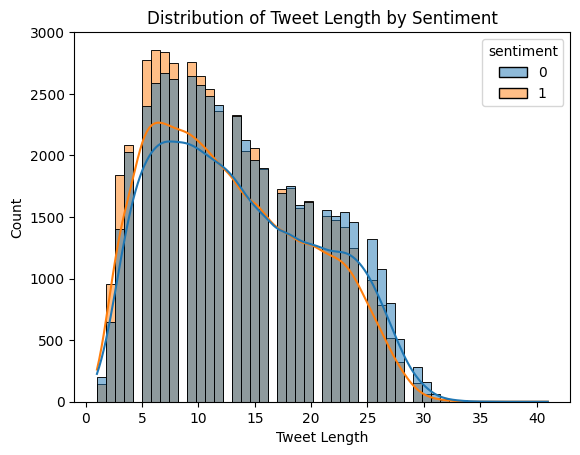

In [71]:
print(df['sentiment'].value_counts(normalize=True))
df['text_len'] = df['text'].apply(lambda x: len(x.split()))

sns.histplot(data=df, x='text_len', hue='sentiment', bins=50, kde=True)
plt.title("Distribution of Tweet Length by Sentiment")
plt.xlabel("Tweet Length")
plt.show()

We see that tweets' length is distributed similarly for positive and negative tweets. Weird enough, we don't see long tweets.

Now let's check if negativity of positivity in tweets changes over the time

C:\Users\bezpa\AppData\Local\Temp\ipykernel_6800\2960056530.py:1: FutureWarning: Parsed string "Tue Jun 16 18:18:12 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


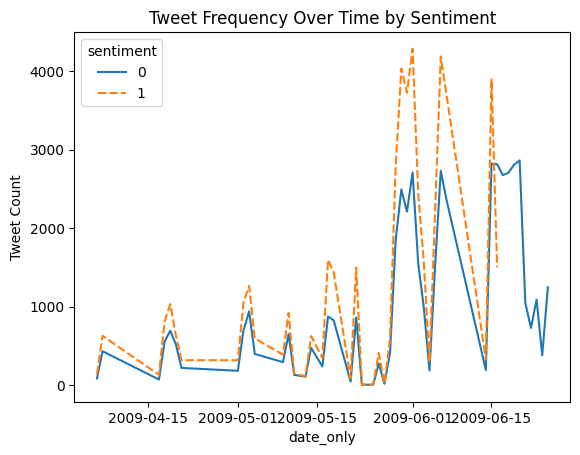

In [17]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date_only'] = df['date'].dt.date

sns.lineplot(data=df.groupby(['date_only', 'sentiment']).size().unstack())
plt.title("Tweet Frequency Over Time by Sentiment")
plt.ylabel("Tweet Count")
plt.show()

Very old tweets here. Also, from the previous plot we see that max length for the tweets is 150 which is not the case for youtube. We should account for that to not create a biased portion of data.

C:\Users\bezpa\AppData\Local\Temp\ipykernel_6800\1135425872.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\bezpa\Anaconda_Navigator\envs\data_for_ml\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


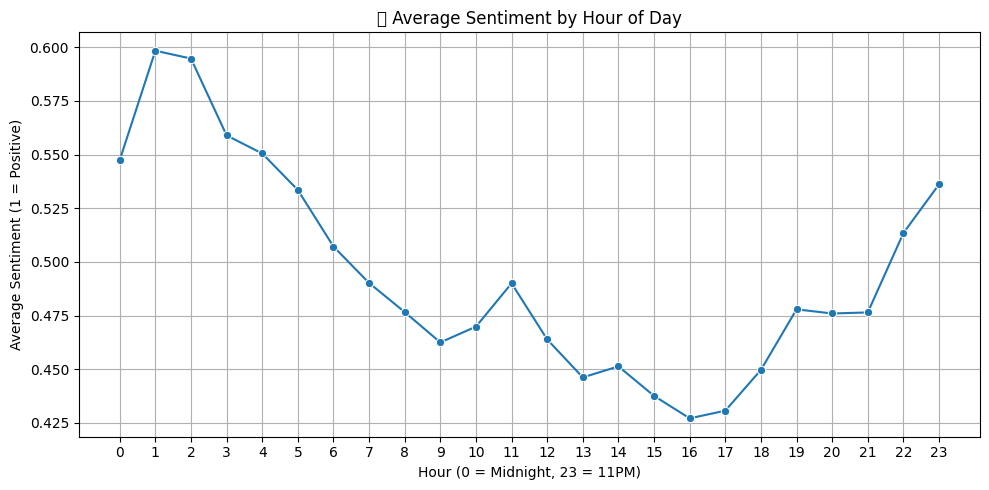

In [19]:
# Extract hour from datetime
df['hour'] = df['date'].dt.hour

# Sentiment proportion per hour
hourly_sentiment = df.groupby('hour')['sentiment'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_sentiment.index, y=hourly_sentiment.values, marker='o')
plt.title('📊 Average Sentiment by Hour of Day')
plt.xlabel('Hour (0 = Midnight, 23 = 11PM)')
plt.ylabel('Average Sentiment (1 = Positive)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

Let's only leave pure text and see which words are the most common for each class

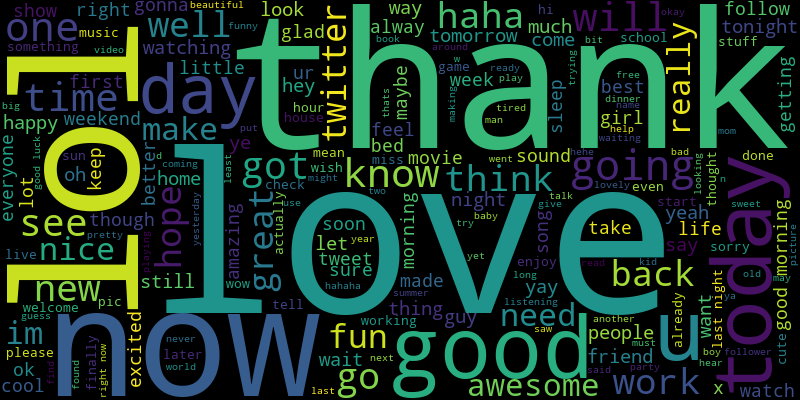

In [28]:
def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = html.unescape(text)                         # Convert HTML entities like &quot; to actual characters
    text = re.sub(r"http\S+", "", text)                # Remove URLs
    text = re.sub(r"www\S+", "", text)                 # Remove www links
    text = re.sub(r"@\w+", "", text)                   # Remove mentions
    text = re.sub(r"#\w+", "", text)                   # Remove hashtags
    text = re.sub(r"[^\w\s']", " ", text)              # Remove punctuation (keep words & contractions)
    text = re.sub(r"\s+", " ", text).strip()           # Remove extra whitespace
    return text.lower()

df['clean_text'] = df['text'].apply(clean_text)

pos_words = " ".join(df[df['sentiment'] == 1]['clean_text'])
neg_words = " ".join(df[df['sentiment'] == 0]['clean_text'])

WordCloud(width=800, height=400).generate(pos_words).to_image()

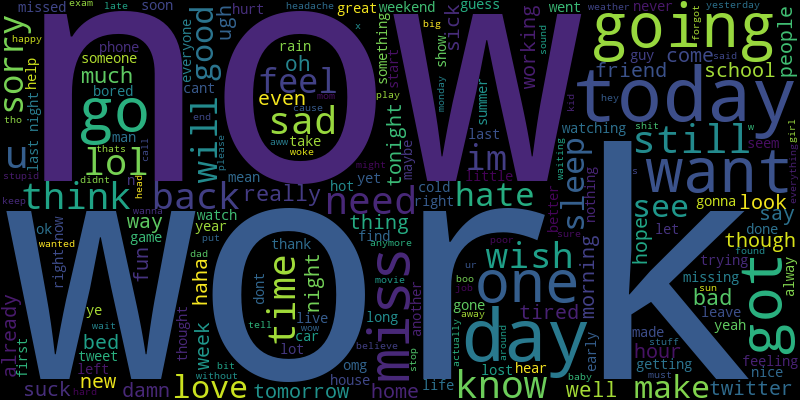

In [30]:
WordCloud(width=800, height=400).generate(neg_words).to_image()

Apparently work makes people not very happy...

## Now for the youtube

In [ ]:
df = pd.read_parquet('../data/raw/youtube_comments_df.parquet')
df.drop_duplicates('comment', inplace=True)

In [56]:
df.head()

,topic,video_id,comment,time,author,channel,votes,replies,heart,reply
0,pet care tips,EkK3D61m_UY,Pinned Comment:\r\nAsk Your Queries We Will Al...,8 months ago,@petscaringhub,UCKor5sY97P5NBGbTEcvrMpA,0.0,NaN,False,False
1,pet care tips,EkK3D61m_UY,Recommended for all new pet owners,8 months ago,@evereststorez,UC91IX70vArxIaEXxx7u3Xdw,0.0,NaN,True,False
4,pet care tips,4cMAIhM37ME,I love cats too,2 weeks ago,@sekinatasorona3854,UC5WnB1tXwy5jROvjtRu72aA,0.0,NaN,True,False
5,pet care tips,4cMAIhM37ME,How can you dad not hear you right here 0:32,3 weeks ago (edited),@JessicaSimpson-v2k,UCEsVHhpRR1DWcYyDZ2dpMoA,0.0,NaN,False,False
6,pet care tips,4cMAIhM37ME,I love cats❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤,2 months ago,@nalu64,UCGsalKkSdPH0iT14KqmD9zA,0.0,1.0,True,False


In [57]:
df.shape

(60851, 10)

C:\Users\bezpa\AppData\Local\Temp\ipykernel_6800\2001004906.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_topics.values, y=top_topics.index, palette='Blues_r')
C:\Users\bezpa\AppData\Local\Temp\ipykernel_6800\2001004906.py:7: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\bezpa\Anaconda_Navigator\envs\data_for_ml\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


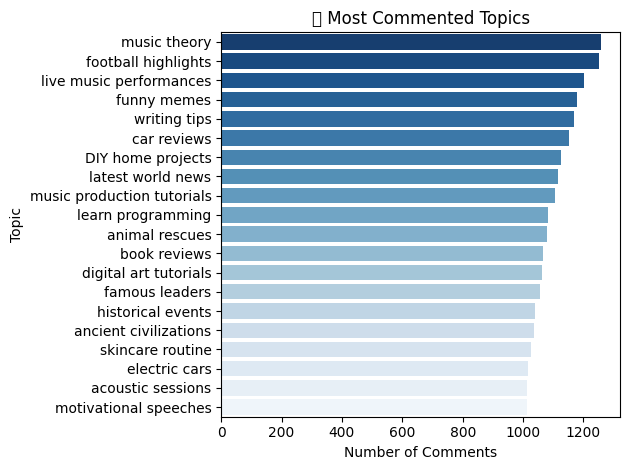

In [59]:
top_topics = df['topic'].value_counts().head(20)

sns.barplot(x=top_topics.values, y=top_topics.index, palette='Blues_r')
plt.title("📚 Most Commented Topics")
plt.xlabel("Number of Comments")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

C:\Users\bezpa\AppData\Local\Temp\ipykernel_6800\34549347.py:9: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\bezpa\Anaconda_Navigator\envs\data_for_ml\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


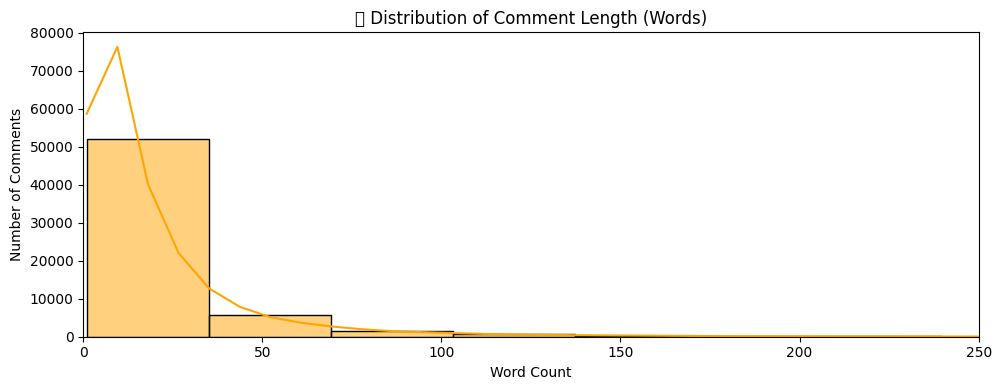

In [76]:
df['word_length'] = df['comment'].astype(str).apply(lambda x: len(x.split()))

# Plot word length
plt.figure(figsize=(10, 4))
sns.histplot(df['word_length'], bins=50, color='orange', kde=True)
plt.title("📝 Distribution of Comment Length (Words)")
plt.xlabel("Word Count")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.xlim(0,250)
plt.show()

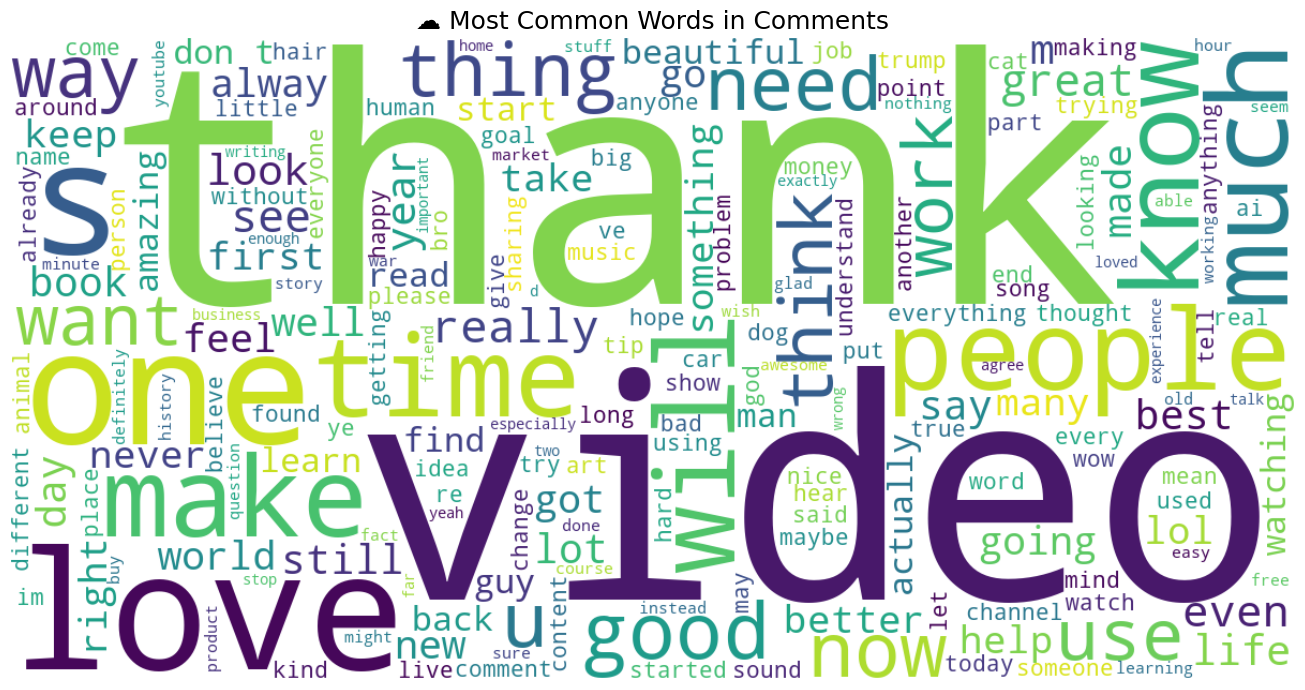

In [93]:
def clean_text(text):
    text = html.unescape(str(text))                          # Decode HTML entities
    text = re.sub(r"http\S+", "", text)                      # Remove URLs
    text = re.sub(r"@\w+", "", text)                         # Remove mentions
    text = re.sub(r"#\w+", "", text)                         # Remove hashtags
    text = re.sub(r"[^\w\s']", " ", text)                    # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()                 # Trim spaces
    return text.lower()

# Clean all comments and remove stopwords
df['cleaned_comment'] = df['comment'].astype(str).apply(clean_text)

# Combine all cleaned comments
all_words = " ".join(df['cleaned_comment'].dropna().tolist())

# Generate WordCloud
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(all_words)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("☁️ Most Common Words in Comments", fontsize=18)
plt.tight_layout()
plt.show()